In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv
/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv


KeyboardInterrupt: 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import copy
import time
import random
import os
from PIL import Image
from IPython.display import display

import torch
import torchvision
from torch import nn, optim
from torchvision import models
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size']=12

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
train_img_dir='../input/state-farm-distracted-driver-detection/imgs/train'
labels = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
test_img_dir = '../input/state-farm-distracted-driver-detection/imgs/test'
sample_sub = pd.read_csv('../input/state-farm-distracted-driver-detection/sample_submission.csv')

In [5]:
display(labels.head())
display(sample_sub.head())

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [6]:
num_training_examples=0
for fol in os.listdir(train_img_dir):
    num_training_examples+=len(os.listdir(os.path.join(train_img_dir,fol)))
assert(num_training_examples == len(labels))
assert(len(os.listdir(test_img_dir)) == len(sample_sub))
print(num_training_examples)

22424


In [7]:
train_data = torchvision.datasets.ImageFolder(root=train_img_dir)

In [8]:
train_data.class_to_idx

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [9]:
train_data.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

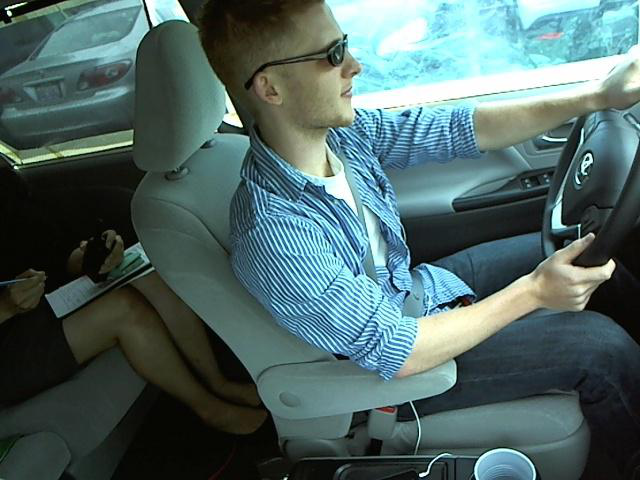

In [10]:
train_data[0][0]

In [11]:
labels.classname.map(train_data.class_to_idx)

0        0
1        0
2        0
3        0
4        0
        ..
22419    9
22420    9
22421    9
22422    9
22423    9
Name: classname, Length: 22424, dtype: int64

In [12]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{images[i][1]}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

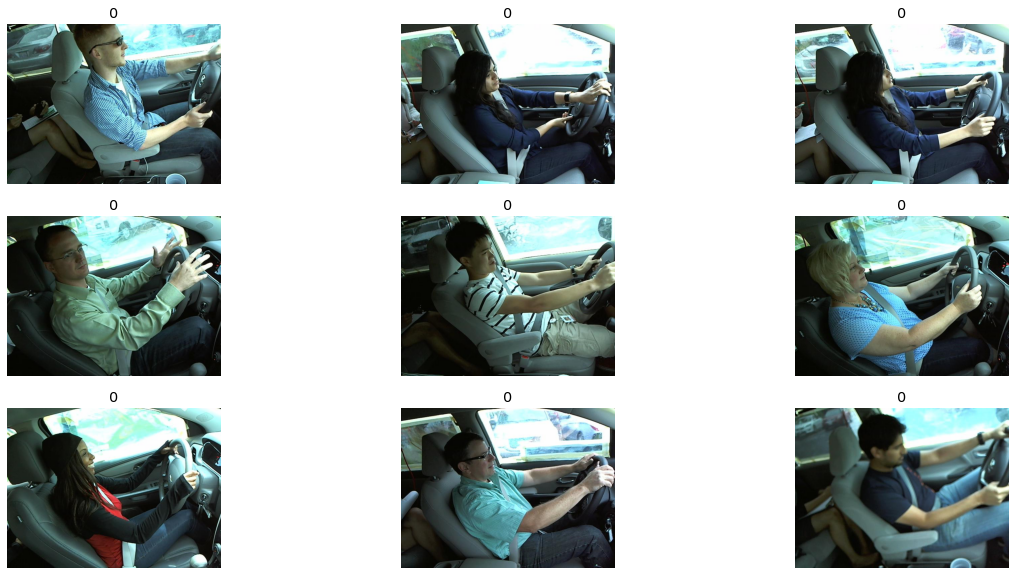

In [13]:
N_images = 9
images = [(image,label) for image,label in [train_data[i] for i in range(N_images)]]
plot_images(images)

In [14]:
VALID_RATIO = 0.9
n_train_examples = int((len(train_data))*VALID_RATIO)
n_valid_examples = len(train_data)-n_train_examples

In [15]:
train_data, valid_data = torch.utils.data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [16]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
train_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
test_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

In [17]:
train_data.dataset.transform = train_transforms
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [18]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 20181
Number of validation examples: 2243


In [19]:
BATCH_SIZE=16
train_iterator=DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator=DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE*2)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [21]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = Variable(torch.FloatTensor(np.array(x))).to(device)
        y = Variable(torch.LongTensor(y)).to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = Variable(torch.FloatTensor(np.array(x))).to(device)
            y = Variable(torch.LongTensor(y)).to(device)
        
            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs):
    """ Fits a dataset to model"""
    best_valid_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    for epoch in range(epochs):
    
        start_time = time.time()
    
        train_loss, train_acc = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, loss_criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc*100)
        valid_accs.append(valid_acc*100)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
    return pd.DataFrame({f'{model_name}_Training_Loss':train_losses, 
                        f'{model_name}_Training_Acc':train_accs, 
                        f'{model_name}_Validation_Loss':valid_losses, 
                        f'{model_name}_Validation_Acc':valid_accs})

In [24]:
def plot_training_statistics(train_stats, model_name):
    
    fig, axes = plt.subplots(2, figsize=(15,15))
    axes[0].plot(train_stats[f'{model_name}_Training_Loss'], label=f'{model_name}_Training_Loss')
    axes[0].plot(train_stats[f'{model_name}_Validation_Loss'], label=f'{model_name}_Validation_Loss')
    axes[1].plot(train_stats[f'{model_name}_Training_Acc'], label=f'{model_name}_Training_Acc')
    axes[1].plot(train_stats[f'{model_name}_Validation_Acc'], label=f'{model_name}_Validation_Acc')
    
    axes[0].set_xlabel("Number of Epochs"), axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Number of Epochs"), axes[1].set_ylabel("Accuracy in %")
    
    axes[0].legend(), axes[1].legend()

In [25]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=3c08651833784691fec919d96a5560d1dd5a6e7147eb92496f3aa68f25c7c5a4
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch


In [26]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [27]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [28]:
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [29]:
model._fc = nn.Sequential(nn.Linear(in_features=2560,out_features=10))

In [30]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

63,812,570 total parameters.
336,330 training parameters.


In [31]:
model= model.to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-2)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 336,330 trainable parameters


In [32]:
train_stats_model = fit_model(model, 'EfficientNet', train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs=2)

Epoch: 01 | Epoch Time: 15m 2s
	Train Loss: 0.371 | Train Acc: 89.70%
	 Val. Loss: 0.197 |  Val. Acc: 95.77%
Epoch: 02 | Epoch Time: 14m 20s
	Train Loss: 0.276 | Train Acc: 95.22%
	 Val. Loss: 0.217 |  Val. Acc: 96.79%


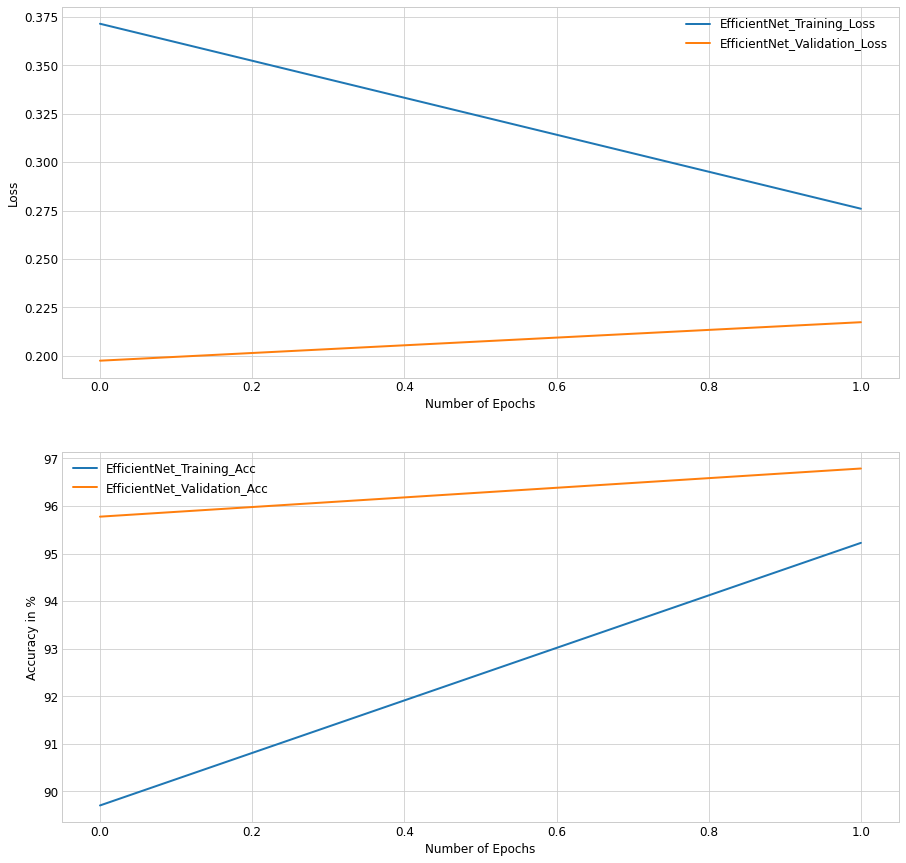

In [35]:
plot_training_statistics(train_stats_model, 'EfficientNet')